In [1]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ranksums
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster
from scipy.spatial.distance import squareform

In [2]:
reactions = pd.read_csv('/Volumes/External/Research/PhD/Kielian_Lab/Data/scRNAseq/2022-07 Hif1a cKO/compass/d14 null vs d14 cre/combined d14 reactions.tsv',
                        sep='\t',
                        index_col=0)

In [3]:
cell_metadata = pd.read_csv('/Volumes/External/Research/PhD/Kielian_Lab/Data/scRNAseq/2022-07 Hif1a cKO/compass/d14 null vs d14 cre/combined d14 metadata.csv',
                            index_col=0)

In [4]:
Null_cells = cell_metadata.index[cell_metadata['cell_type'] == 'Null']
Cre_cells = cell_metadata.index[cell_metadata['cell_type'] == 'Cre']

In [5]:
reaction_metadata = pd.read_csv('/Users/christopherhorn/Library/Python/3.8/lib/python/site-packages/compass/Resources/Recon2_export/rxn_md.csv',
                                index_col=0)

In [6]:
def cohens_d(x, y):
    pooled_std = np.sqrt(((len(x)-1) * np.var(x, ddof=1) + (len(y)-1) * np.var(y, ddof=1)) / (len(x) + len(y)-2))
    
    return (np.mean(x) - np.mean(y)) / pooled_std
    

def wilcoxon_test(consistencies_matrix, group_A_cells, group_B_cells):
    '''
        Performs an unpaired wilcoxon test (or mann-whitney U test) for each reaction between group_A and group_B
    '''
    #per reaction/meta-reaction, conduct wilcoxon test between group_A and group_B
    group_A = consistencies_matrix.loc[:,group_A_cells]
    group_B = consistencies_matrix.loc[:,group_B_cells]
    results = pd.DataFrame(index=consistencies_matrix.index, columns=['wilcox_stat', 'wilcox_pval', 'cohens_d'], dtype='float64')
    
    for rxn in consistencies_matrix.index:
        A, B = group_A.loc[rxn].to_numpy().ravel(), group_B.loc[rxn].to_numpy().ravel()
        stat, pval = mannwhitneyu(A, B, alternative='two-sided')
        c_d = cohens_d(A, B)
        results.loc[rxn, ['wilcox_stat', 'wilcox_pval', 'cohens_d']] = stat, pval, c_d
    
    results['adjusted_pval'] = np.array(multipletests(results['wilcox_pval'], method='fdr_bh')[1], dtype='float64')
    
    return results

In [7]:
def get_reaction_consistencies(compass_reaction_scores, min_range=1e-3):
    df = -np.log(compass_reaction_scores + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    
    return df

In [8]:
labeled_reactions = {'PGM_neg' : 'phosphoglycerate mutase (PGAM)',
                     'LDH_L_neg' : 'lactate dehydrogenase',
                     'PDHm_pos' : 'pyruvate dehydrogenase (PDH)',
                     'TPI_neg' : 'triosephosphate isomerase (DHAP forming)',
                     'FACOAL1821_neg' : 'long-chain fatty-acid-CoA ligase',
                     'r1257_pos' : 'long-chain fatty-acid-CoA ligase',
                     'FACOAL1831_neg' : 'long-chain fatty-acid-CoA ligase',
                     'CSNATr_neg' : 'carnitine O-acetyltransferase',
                     'C160CPT1_pos' : 'carnitine O-palmitoyltransferase',
                     'ACONTm_pos' : 'aconitate hydratase',
                     'SUCOASm_pos' : 'succinate-CoA ligase',
                     'AKGDm_pos' : 'alpha-ketoglutarate dehydrogenase',
                     'SUCD1m_pos' : 'succinate dehydrogenase',
                     'ICDHyrm_pos' : 'isocitrate dehydrogenase',
                     'CK_pos' : 'creatine\nkinase',
                     'PGCD_pos' : 'phosphoglycerate dehydrogenase',
                     'ARGSS_pos' : 'arginosuccinate synthase',
                     'r0281_neg' : 'putrescine diamine oxidase',
                     'SPMDOX_pos' : 'spermidine dehydrogenase (spermidine -> GABA)',
                     'ARGDCm_pos' : 'arginine decarboxylase',
                     'AGMTm_pos' : 'agmatinase',
                     'GHMT2r_pos' : 'serine hydroxymethyltransferase',
                     'AHC_pos' : 'adenosylhomocysteinase',
                     'METAT_pos' : 'methionine adenosyltransferase',
                     'METS_pos' : 'methionine\nsynthase',
                     'ARGN_pos' : 'arginase'}

In [10]:
def plot_differential_scores(data, title, c):
    plt.figure(figsize=(10,10))
    axs = plt.gca()
    axs.scatter(data['cohens_d'], -np.log10(data['adjusted_pval']), c=c)
    axs.set_xlabel("Cohen's d", fontsize=16)
    axs.set_ylabel('-log10 (Wilcoxon-adjusted p)', fontsize=16)
    # Everything after this should be tweaked depending on your application
    axs.set_xlim(-5.2, 5.2)
    axs.axvline(0, dashes=(3,3), c='black')
    axs.axhline(1, dashes=(3,3), c='black')
    axs.set_title(title, fontdict={'fontsize':20})
    axs.annotate('',
                 xy=(0.5, -0.08),
                 xycoords='axes fraction',
                 xytext=(0, -0.08),
                 arrowprops=dict(arrowstyle='<-',
                                 color='#348C73',
                                 linewidth=4))
    
    axs.annotate('Null', xy=(0.75, -0.12), xycoords='axes fraction', fontsize=16)
    axs.annotate('',
                 xy=(0.5, -0.08),
                 xycoords='axes fraction',
                 xytext=(1, -0.08),
                 arrowprops=dict(arrowstyle='<-',
                                 color='#E92E87',
                                 linewidth=4))
    
    axs.annotate('Cre', xy=(0.25, -0.12), xycoords='axes fraction', fontsize=16)
    
    for r in data.index:
        if r in labeled_reactions:
            x = data.loc[r, 'cohens_d']
            y = -np.log10(data.loc[r, 'adjusted_pval'])
            offset = (20, 0)
            if x < 0:
                offset = (-100, -40)
            axs.annotate(labeled_reactions[r],
                         (x,y),
                         xytext = offset,
                         textcoords='offset pixels',
                         arrowprops={'arrowstyle':'-'})

In [11]:
amino_acid_metab = ['Alanine and aspartate metabolism',
                    'Arginine and Proline Metabolism',
                    'beta-Alanine metabolism',
                    'Cysteine Metabolism',
                    'D-alanine metabolism',
                    'Folate metabolism',
                    'Glutamate metabolism',
                    'Glycine, serine, alanine and threonine metabolism',
                    'Histidine metabolism',
                    'Lysine metabolism',
                    'Methionine and cysteine metabolism',
                    'Taurine and hypotaurine metabolism',
                    'Tryptophan metabolism',
                    'Tyrosine metabolism',
                    'Urea cycle',
                    'Valine, leucine, and isoleucine metabolism']

In [12]:
## Metareactions
reactions = pd.read_csv('/Volumes/External/Research/PhD/Kielian_Lab/Data/scRNAseq/2022-07 Hif1a cKO/compass/d14 null vs d14 cre/combined d14 reactions.tsv',
                        sep='\t',
                        index_col=0)

reactions[reactions <= 1e-4] = 0
reactions = reactions[np.all(reactions != 0, axis=1)]

In [13]:
reactions = reactions[reactions.max(axis=1) - reactions.min(axis=1) != 0]

In [14]:
def get_metareactions(reactions, height=0.02):
    '''
        Returns an array of metareaction labels for each reaction
        Index k in the returned array has the metareaction label for reaction k.
    '''
    # pairwise_reaction_correlations = reactions.T.corr(method='spearman') #Pandas method here is orders of magnitude slower
    pairwise_reaction_correlations = np.corrcoef(reactions.rank(axis=1))
    # Unfortunately due to floating point issues, these matrices are not always perfectly symmetric and the diagonal may be slightly off from 1
    pairwise_reaction_correlations[np.arange(reactions.shape[0]), np.arange(reactions.shape[0])] = 1.0
    pairwise_reaction_correlations = (pairwise_reaction_correlations + pairwise_reaction_correlations.T) / 2
    assert(np.all(pairwise_reaction_correlations == pairwise_reaction_correlations.T))

    Z = hcluster.complete(squareform(1 - pairwise_reaction_correlations))
    
    return hcluster.fcluster(Z, height, criterion='distance')

In [15]:
meta_rxns_map = get_metareactions(reactions)
meta_rxns = reactions.join(pd.DataFrame(meta_rxns_map,
                                        columns=['meta_rxn_id'],
                                        index=reactions.index)).groupby('meta_rxn_id').mean()

In [16]:
meta_rxn_consistencies = get_reaction_consistencies(meta_rxns)

In [17]:
meta_rxn_expanded = pd.DataFrame(index=reactions.index, columns=meta_rxn_consistencies.columns)

for i in range(len(meta_rxn_expanded.index)):
    if (meta_rxns_map[i] in meta_rxn_consistencies.index):
        meta_rxn_expanded.loc[meta_rxn_expanded.index[i]] = meta_rxn_consistencies.loc[meta_rxns_map[i]]

meta_rxn_expanded = meta_rxn_expanded.dropna().astype('float64')
meta_rxn_expanded['metadata_r_id'] = ''

for r in meta_rxn_expanded.index:
    if r in reaction_metadata.index:
        meta_rxn_expanded.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        meta_rxn_expanded.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print('Should not occur')

meta_rxn_expanded = meta_rxn_expanded.merge(reaction_metadata,
                                            how='left',
                                            left_on='metadata_r_id',
                                            right_index=True,
                                            validate='m:1')

meta_rxn_expanded = meta_rxn_expanded[meta_rxn_expanded['rxn_confidence'].isin([0,4])]
meta_rxn_expanded = meta_rxn_expanded[~meta_rxn_expanded['rxn_EC_number'].isna()]
meta_rxn_expanded.loc[(meta_rxn_expanded['rxn_formula'].map(lambda x: '[m]' not in x)) & (meta_rxn_expanded['subsystem'] == 'Citric acid cycle'), 'subsystem'] = 'Other'

filtered_meta_rxn_consist = pd.concat([meta_rxn_expanded[meta_rxn_expanded['subsystem'] == 'Glycolysis/gluconeogenesis'],
                                       meta_rxn_expanded[meta_rxn_expanded['subsystem'] == 'Citric acid cycle'],
                                       meta_rxn_expanded[meta_rxn_expanded['subsystem'].isin(amino_acid_metab)],
                                       meta_rxn_expanded[meta_rxn_expanded['subsystem'] == 'Fatty acid oxidation']])

In [18]:
# meta_rxn_expanded.to_csv('/Volumes/External/Research/PhD/Kielian_Lab/Data/scRNAseq/2022-07 Hif1a cKO/compass/d14 null vs d14 cre/d14 null vs cre compass metareaction consistencies.csv')

In [19]:
wilcox_meta_rxn_results = wilcoxon_test(meta_rxn_consistencies, Null_cells, Cre_cells)

In [20]:
wilcox_meta_rxn_expanded = pd.DataFrame(index=reactions.index, columns=wilcox_meta_rxn_results.columns)

for i in range(len(wilcox_meta_rxn_expanded.index)):
    if (meta_rxns_map[i] in wilcox_meta_rxn_results.index):
        wilcox_meta_rxn_expanded.loc[wilcox_meta_rxn_expanded.index[i]] = wilcox_meta_rxn_results.loc[meta_rxns_map[i]]

wilcox_meta_rxn_expanded = wilcox_meta_rxn_expanded.dropna().astype('float64')

In [21]:
wilcox_meta_rxn_expanded['metadata_r_id'] = ''

for r in wilcox_meta_rxn_expanded.index:
    if r in reaction_metadata.index:
        wilcox_meta_rxn_expanded.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_meta_rxn_expanded.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print('Should not occur')

In [22]:
W = wilcox_meta_rxn_expanded.merge(reaction_metadata,
                                   how='left',
                                   left_on='metadata_r_id',
                                   right_index=True,
                                   validate='m:1')

W = W[W['rxn_confidence'].isin([0,4])]
W = W[~W['rxn_EC_number'].isna()]
W.loc[(W['rxn_formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == 'Citric acid cycle'), 'subsystem'] = 'Other'

In [23]:
filtered_data = pd.concat([W[W['subsystem'] == 'Glycolysis/gluconeogenesis'],
                           W[W['subsystem'] == 'Citric acid cycle'],
                           W[W['subsystem'].isin(amino_acid_metab)],
                           W[W['subsystem'] == 'Fatty acid oxidation']])

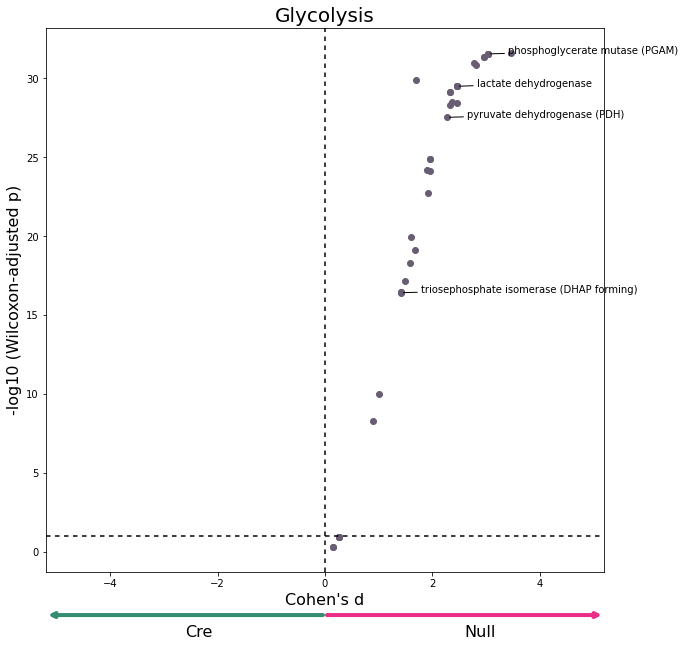

In [24]:
data = W[W['subsystem'] == 'Glycolysis/gluconeogenesis']
plot_differential_scores(data, title='Glycolysis', c='#695D73')

# plt.savefig('/Volumes/External/Research/PhD/Kielian_Lab/Data/Compass_metabolism/Integrated_ortho/glycolysis.png',
#             bbox_inches='tight',
#             dpi=300,
#             transparent=False,
#             facecolor='white')

In [ ]:
data = W[W['subsystem'] == 'Citric acid cycle']
plot_differential_scores(data, title='TCA Cycle', c='#D3A991')

# plt.savefig('/Volumes/External/Research/PhD/Kielian_Lab/Data/Compass_metabolism/Integrated_ortho/tca_cycle.png',
#             bbox_inches='tight',
#             dpi=300,
#             transparent=False,
#             facecolor='white')

In [ ]:
data = W[W['subsystem'].isin(amino_acid_metab)].copy()
data['adjusted_pval'] = data['adjusted_pval']
plot_differential_scores(data, 'Amino Acid Metabolism', c='#BF1E2E')

# plt.savefig('/Volumes/External/Research/PhD/Kielian_Lab/Data/Compass_metabolism/Integrated_ortho/amino_acid.png',
#             bbox_inches='tight',
#             dpi=300,
#             transparent=False,
#             facecolor='white')

In [ ]:
data = W[W['subsystem'] == 'Fatty acid oxidation']
plot_differential_scores(data, 'Fatty Acid Oxidation', c='#040772')

# plt.savefig('/Volumes/External/Research/PhD/Kielian_Lab/Data/Compass_metabolism/Integrated_ortho/fatty_acid.png',
#             bbox_inches='tight',
#             dpi=300,
#             transparent=False,
#             facecolor='white')

In [25]:
data = W[~W['subsystem'].isin(['Miscellaneous', 'Unassigned'])]
data = data[~data['subsystem'].map(lambda x: 'Transport' in x or 'Exchange' in x or x == 'Other')]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] # filter(n() > 5)
data = data[data['subsystem'].isin(items)]

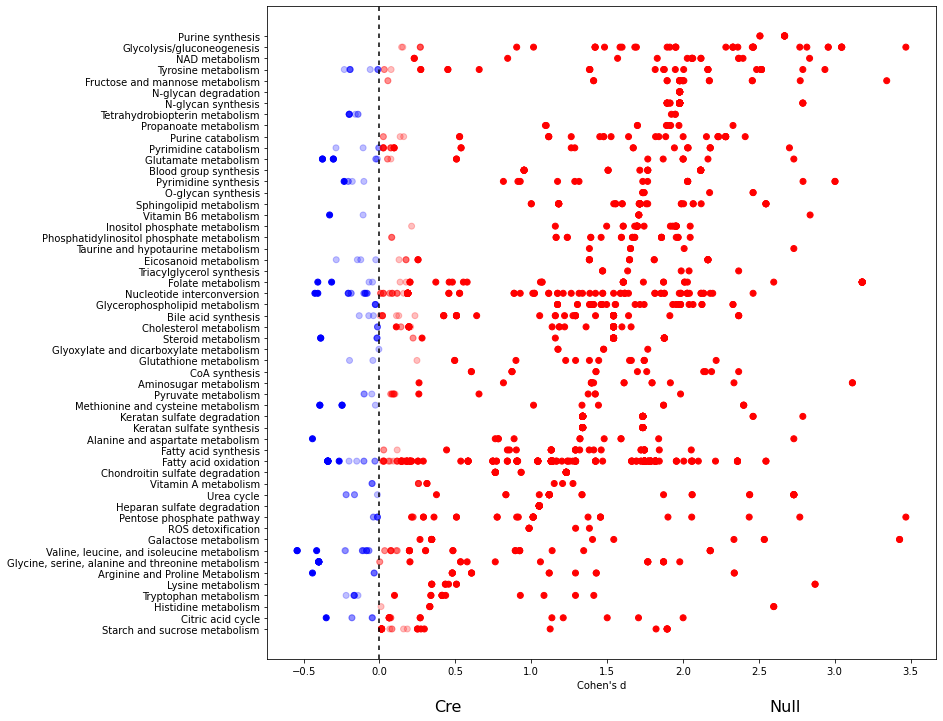

In [27]:
plt.figure(figsize=(12,12))
axs = plt.gca()
# Sorts the reactions for plotting
d = data[data['adjusted_pval'] < 0.1].groupby('subsystem')['cohens_d'].median().abs()
axs.scatter(d[d.argsort], d[d.argsort].index, alpha=0)
color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'b')
alpha = data['adjusted_pval'].map(lambda x: 1.0 if x < 0.1 else 0.25)
axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)
axs.set_xlabel("Cohen's d")
axs.axvline(0, dashes=(3,3), c='black')
axs.annotate('Null', xy=(0.75, -0.08), xycoords='axes fraction', fontsize=16)
axs.annotate('Cre', xy=(0.25, -0.08), xycoords='axes fraction', fontsize=16)

# plt.savefig('/Volumes/External/Research/PhD/Kielian_Lab/Data/scRNAseq/2022-07 Hif1a cKO/output/Figures/cmp_d14 cohens subsystem dots.png',
#             bbox_inches='tight',
#             dpi=300,
#             transparent=False,
#             facecolor='white')

In [28]:
# W.to_csv('/Volumes/External/Research/PhD/Kielian_Lab/Data/scRNAseq/2022-07 Hif1a cKO/compass/d14 null vs d14 cre/d14 null vs cre compass analysis results.csv')